# Correlation matrix

In [545]:
import h5py
import pandas as pd
import seaborn as sns

%pylab inline
matplotlib.rcParams['figure.figsize'] = (40.0, 40.0)

Populating the interactive namespace from numpy and matplotlib


In [694]:
def load_data(datafile, namefile):
    data_hdf5 = h5py.File(datafile)['traindata']
    names = np.array(open(namefile).read().split(','))
    return (data_hdf5, names)

def subsample(data_hdf5, n):
    N = data_hdf5.shape[-1]
    indices = sorted(np.random.choice(
        N, n, replace=False))
    return data_hdf5[:,indices].T

datafile = "/Users/alexyku/Desktop/tmp/deepsea_train/train.mat"
namefile = './deepsea_label_names.txt'
data_hdf5, names = load_data(datafile, namefile)

# subsample data
X = subsample(data_hdf5, n=1000)

# features with no binding events
nan_names = names[np.equal(np.sum(X, axis=0), 0)]
tf_names = names[125:815]  # transcription factors

# compute correlation matrix
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
Z = (X - mean) / (std + 1e-9)  # ignore warning...
C = Z.T.dot(Z) / Z.shape[0]

# convert to dataframe
df = pd.DataFrame(C)
df.columns = names
df.index = names

# drop duplicate features
indices = [list(names).index(x) for x in set(names)]
df = df.iloc[indices, indices]

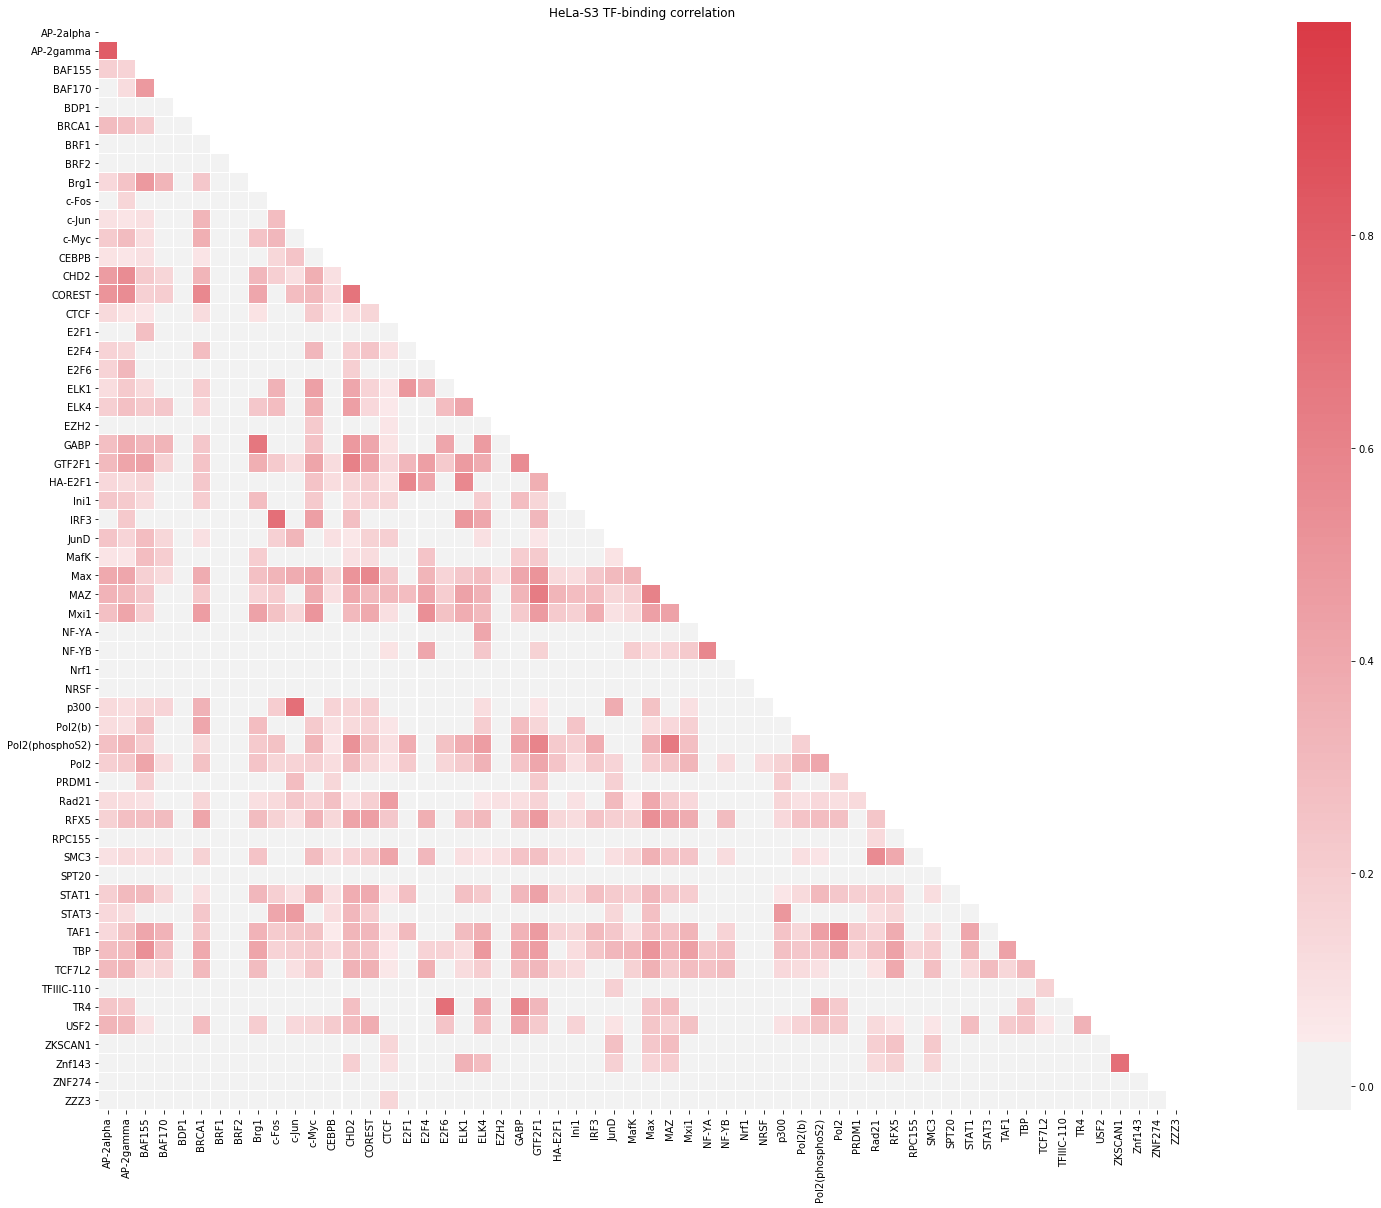

In [695]:
def plot_correlation(df, **kwargs):
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    def maybe_add(kwargs, key, value):
        if key not in kwargs:
            kwargs[key] = value
    maybe_add(kwargs, 'mask', mask)
    maybe_add(kwargs, 'cmap', cmap)
    maybe_add(kwargs, 'linewidths', 0)  # 0.05
    maybe_add(kwargs, 'square', True)
    maybe_add(kwargs, 'center', 0)
    sns.heatmap(df, **kwargs)

# filter features
filter_fn = lambda x: (('HeLa-S3' in x) and (x in tf_names))
filtered_names = np.unique(list(filter(filter_fn, names)))
filtered_names = sorted(filtered_names, key=str.lower)
filtered_df = df.loc[filtered_names, filtered_names]

# pretty names for printing
filtered_df.columns = [x.split('|')[1] for x in filtered_df.columns]
filtered_df.index = [x.split('|')[1] for x in filtered_df.index]

plt.figure(figsize=(40.0, 20.0))
plt.title('HeLa-S3 TF-binding correlation')
plot_correlation(filtered_df, linewidths=0.05)

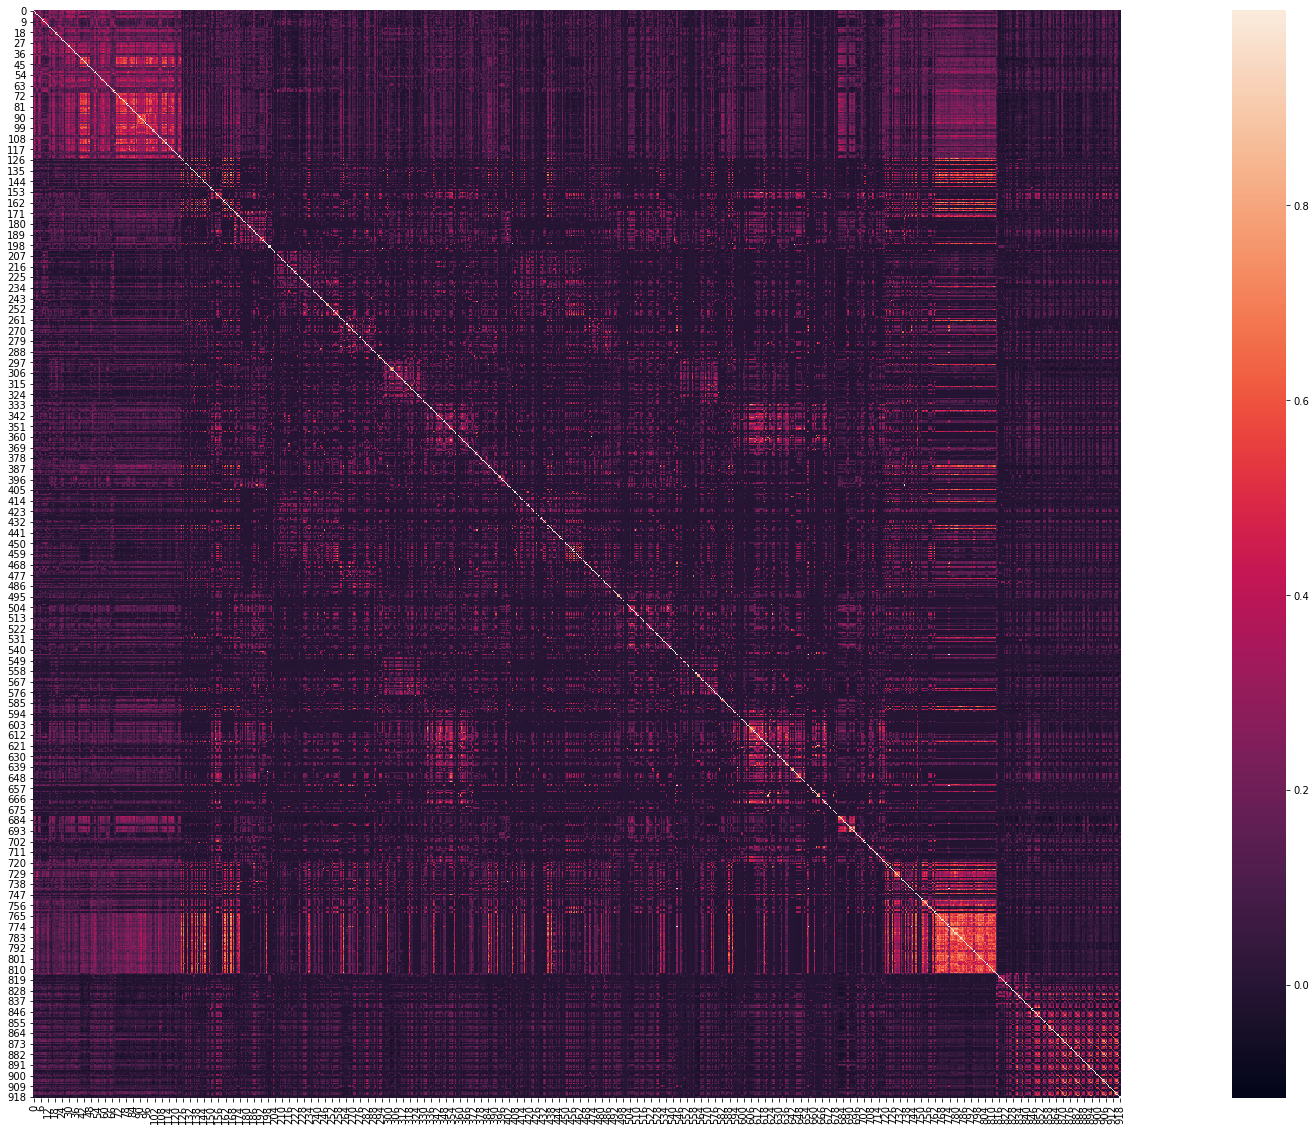

In [692]:
# all 919 features
plt.figure(figsize=(40.0, 20.0))
sns.heatmap(C, square=True);